<a href="https://colab.research.google.com/github/Pawan-choudhary/MediScan-Disease-Identifier/blob/main/MediscanDiseaseIdentifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

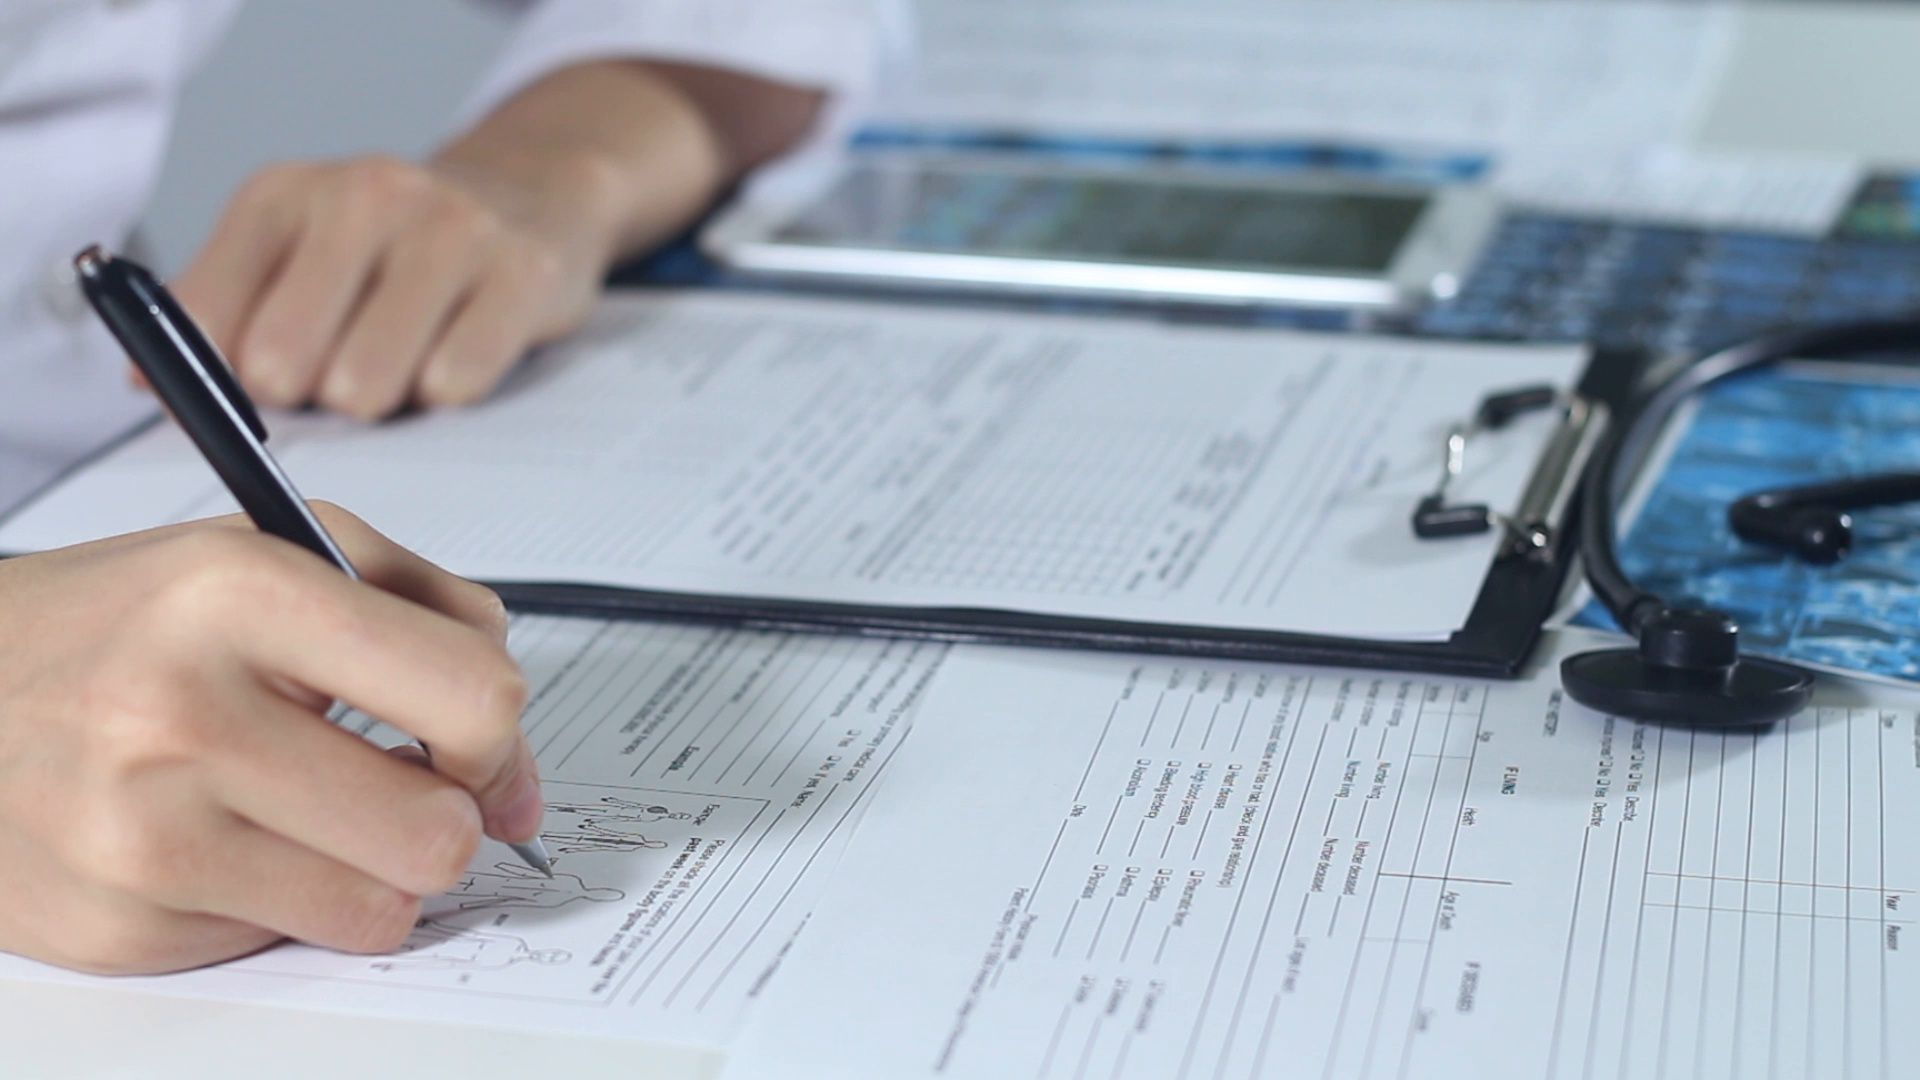

# Business Case

* You are a Data scientist working in a Medical Research publication company.
* As 100s of articles are published every single day, the organizers wants to identify which diseases are being spoke in the article.
* Manually reading the articles and identifying the disease is a laborious process.
* As a data scientist you are asked, if you can train a machine Learning model to automatically  identify the diseases mentioned in the corpus with the limited training data available

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import Image
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## BERT?

* BERT stands for BiDirectional Encoder Representation from Transformers released by Google Research team in 2018
* BERT uses only the Encoder portion of the transformer's architecture which is the reason it's called <b>Encoder Representation from transformers.</b>

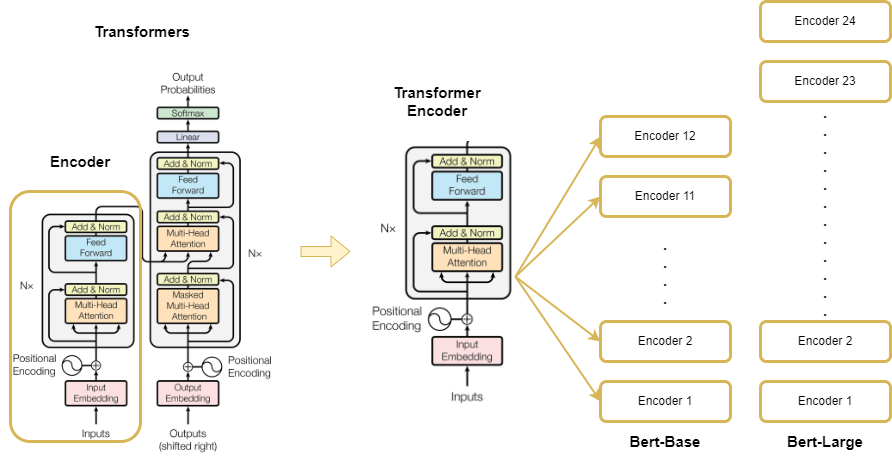

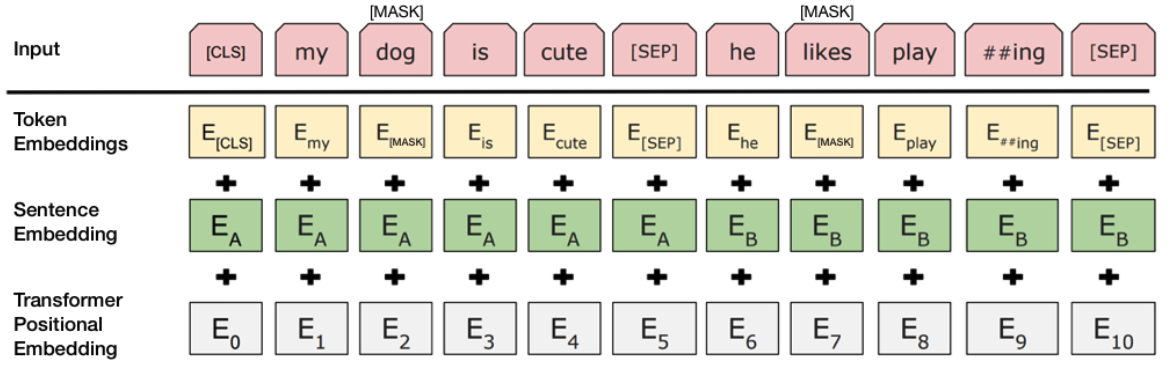

---
# How are the words tokenized in Bert?
---

* Word Piece Tokenizer method

  - Bert uses a special tokenization mechanism called the WordPiece Tokenizer where compound words are split into root word and subwords separated with <b>##</b>.
  - The word-based tokenizer suffers from very large vocabulary, large number of OOV tokens which is addressed by Word Piece Tokenizer

* Let's look at a example

In [ ]:
words = ['parachute', 'paraglide', 'paragliding', 'scubadiving', 'scubadiver', 'scubadive']

for word in words:
    tok_word = tokenizer.tokenize(word)
    print(f'{word:<12} tokenized to {tok_word}')

parachute    tokenized to ['parachute']
paraglide    tokenized to ['para', '##gli', '##de']
paragliding  tokenized to ['para', '##gli', '##ding']
scubadiving  tokenized to ['scuba', '##di', '##ving']
scubadiver   tokenized to ['scuba', '##di', '##ver']
scubadive    tokenized to ['scuba', '##di', '##ve']


# Code implementation

In [ ]:
from transformers import TFBertForTokenClassification
from transformers import BertTokenizer
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

---
# Reading the training dataset & Exploratory Data Analysis
---

In [ ]:
!gdown 1cYbdeIWENeNLeFyovNUpVrGCns1OdR_z
!gdown 1bSt1p9beLkH15kGKHjY3BK5jqmuLKNRn
!gdown 1A4pa0O1o4q2a2Iq8-yud5dwH3yOwDz4Q

Downloading...

From: https://drive.google.com/uc?id=1cYbdeIWENeNLeFyovNUpVrGCns1OdR_z

To: /content/NCBI_corpus_development.txt

100% 165k/165k [00:00<00:00, 115MB/s]

Downloading...

From: https://drive.google.com/uc?id=1bSt1p9beLkH15kGKHjY3BK5jqmuLKNRn

To: /content/NCBI_corpus_testing.txt

100% 174k/174k [00:00<00:00, 104MB/s]

Downloading...

From: https://drive.google.com/uc?id=1A4pa0O1o4q2a2Iq8-yud5dwH3yOwDz4Q

To: /content/NCBI_corpus_training.txt

100% 960k/960k [00:00<00:00, 149MB/s]


In [ ]:
train_path = "/kaggle/input/mediscan-disease-dataset/NCBI_corpus_training.txt"
dev_path = "/kaggle/input/mediscan-disease-dataset/NCBI_corpus_development.txt"
test_path = "/kaggle/input/mediscan-disease-dataset/NCBI_corpus_testing.txt"

train_set = pd.read_csv(train_path,
                        sep="\t",
                        on_bad_lines='skip',
                       header=None)

dev_set = pd.read_csv(dev_path,
                        sep="\t",
                        on_bad_lines='skip',
                       header=None)

test_set = pd.read_csv(test_path,
                        sep="\t",
                        on_bad_lines='skip',
                       header=None)

df = pd.concat([train_set, dev_set, test_set]).reset_index(drop=True)
df

0                                                  1  \
0    10021369  Identification of APC2, a homologue of the <ca...   
1    10051005  A common MSH2 mutation in English and North Am...   
2    10051007  Age of onset in <category="SpecificDisease">Hu...   
3      100562  <category="SpecificDisease">Familial deficienc...   
4    10064668  Increased incidence of <category="DiseaseClass...   
..        ...                                                ...   
786   9949197  Distribution of emerin and lamins in the heart...   
787   9949209  Genetic mapping of the <category="Modifier">co...   
788   9950360  Molecular analysis of the <category="Modifier"...   
789   9973276  <category="SpecificDisease">Inherited colorect...   
790   9988281  Localization of human BRCA1 and its loss in hi...   

                                                     2  
0    The <category="Modifier">adenomatous polyposis...  
1    The frequency , origin , and phenotypic expres...  
2    Age of onset ( AO ) of <category="SpecificDise...  
3    The serum of a 29-year old woman with a recent...  
4    OBJECTIVE  Previous reports have suggested an ...  
..                                                 ...  
786  Emerin is a nuclear membrane protein which is ...  
787  Abnormal <category="SpecificDisease">hepatic c...  
788  BACKGROUND / AIMS  The development of <categor...  
789  Germ-line and somatic truncating mutations of ...  
790  Although the link between the BRCA1 <category=...  

[791 rows x 3 columns]

# Pre-processing
* The data is split into two columns as 1 and 2. We will combine both into a single column "all_text

In [ ]:
def combine_text(data):
    data = data.rename(columns = {0:'id', 1:'text_1', 2:'text_2'})
    data['all_text'] = data['text_1'] + " " + data['text_2']
    data = data.drop(['text_1', 'text_2'], axis=1)
    data['all_text'] = data.all_text.str.replace('"', "")

    return data

final_set = combine_text(data=df)
final_set

id                                           all_text
0    10021369  Identification of APC2, a homologue of the <ca...
1    10051005  A common MSH2 mutation in English and North Am...
2    10051007  Age of onset in <category=SpecificDisease>Hunt...
3      100562  <category=SpecificDisease>Familial deficiency ...
4    10064668  Increased incidence of <category=DiseaseClass>...
..        ...                                                ...
786   9949197  Distribution of emerin and lamins in the heart...
787   9949209  Genetic mapping of the <category=Modifier>copp...
788   9950360  Molecular analysis of the <category=Modifier>A...
789   9973276  <category=SpecificDisease>Inherited colorectal...
790   9988281  Localization of human BRCA1 and its loss in hi...

[791 rows x 2 columns]

# Word count distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='all_text', ylabel='Count'>

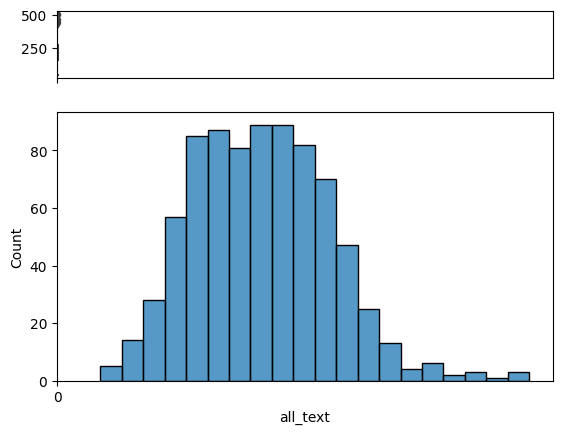

In [ ]:
word_count = final_set.all_text.str.split().str.len()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

# assigning a graph to each ax
sns.boxplot(word_count, ax=ax_box)
sns.histplot(word_count, ax=ax_hist)

### Let's quickly look at 1 sample data

In [ ]:
final_set.all_text[2]

'Age of onset in <category=SpecificDisease>Huntington disease</category> : sex specific influence of apolipoprotein E genotype and normal CAG repeat length . Age of onset ( AO ) of <category=SpecificDisease>Huntington disease</category> ( <category=SpecificDisease>HD</category>) is known to be correlated with the length of an expanded CAG repeat in the <category=Modifier>HD</category> gene . Apolipoprotein E ( APOE ) genotype , in turn , is known to influence AO in <category=SpecificDisease>Alzheimer disease</category> , rendering the APOE gene a likely candidate to affect AO in other <category=DiseaseClass>neurological diseases</category> too . We therefore determined APOE genotype and normal CAG repeat length in the <category=Modifier>HD</category> gene for 138 <category=Modifier>HD</category> patients who were previously analysed with respect to CAG repeat length . Genotyping for APOE was performed blind to clinical information . In addition to highlighting the effect of the normal 

* The dataset contains 4 categories of entities like
    1. Modifier,
    2. SpecificDisease,
    3. DiseaseClass
    4. CompositeMention.
* But in this usecase we will only train a model to identify the <b>SpecificDisease</b>

# More Pre-processing

* The labels are mentioned in between the < category= >   < / category> tags
* We will extract the entities between <category=SpecificDisease> < / category> as labels.
* Once the labels are extracted, we will replace all the tags with spaces.

In [ ]:
def extract_disease_labels(string):

    pattern = "<category=SpecificDisease>(.*?)</category>"
    label = re.findall(pattern, string)
    label = np.unique(label).tolist()

    return label

def replace_tags(string):
    sub_list = ['<category=Modifier>',
                '<category=SpecificDisease>',
                '<category=DiseaseClass>',
                '<category=CompositeMention>',
                '</category>']
    for sub in sub_list:
        string = string.replace(sub, "")

    return string

final_set['label'] = final_set.all_text.apply(lambda x: extract_disease_labels(x))
final_set['train_text'] = final_set.all_text.apply(lambda x: replace_tags(x))
final_set

id                                           all_text  \
0    10021369  Identification of APC2, a homologue of the <ca...   
1    10051005  A common MSH2 mutation in English and North Am...   
2    10051007  Age of onset in <category=SpecificDisease>Hunt...   
3      100562  <category=SpecificDisease>Familial deficiency ...   
4    10064668  Increased incidence of <category=DiseaseClass>...   
..        ...                                                ...   
786   9949197  Distribution of emerin and lamins in the heart...   
787   9949209  Genetic mapping of the <category=Modifier>copp...   
788   9950360  Molecular analysis of the <category=Modifier>A...   
789   9973276  <category=SpecificDisease>Inherited colorectal...   
790   9988281  Localization of human BRCA1 and its loss in hi...   

                                                 label  \
0                                             [cancer]   
1    [HNPCC, colorectal cancer, endometrial cancer,...   
2          [Alzheimer disease, HD, Huntington disease]   
3    [C7 deficiency, Complete absence of C7, Famili...   
4    [CHH, basal cell carcinoma, cartilage-hair hyp...   
..                                                 ...   
786          [EDMD, Emery-Dreifuss muscular dystrophy]   
787  [CT, WD, Wilson disease, copper overload, copp...   
788  [FAP, colorectal cancer, familial adenomatous ...   
789  [Inherited colorectal polyposis, adenomatous p...   
790  [breast malignancies, ductal carcinomas, low-g...   

                                            train_text  
0    Identification of APC2, a homologue of the ade...  
1    A common MSH2 mutation in English and North Am...  
2    Age of onset in Huntington disease : sex speci...  
3    Familial deficiency of the seventh component o...  
4    Increased incidence of cancer in patients with...  
..                                                 ...  
786  Distribution of emerin and lamins in the heart...  
787  Genetic mapping of the copper toxicosis locus ...  
788  Molecular analysis of the APC gene in 205 fami...  
789  Inherited colorectal polyposis and cancer risk...  
790  Localization of human BRCA1 and its loss in hi...  

[791 rows x 4 columns]

In [ ]:
ind = 1

print('Before preprocessing:')
print()
print(final_set.all_text[ind])
print()
print('After preprocessing')
print()
print(final_set.train_text[ind])
print()
print('Labels:')
print(final_set.label[ind])


Before preprocessing:

A common MSH2 mutation in English and North American <category=Modifier>HNPCC</category> families: origin, phenotypic expression, and sex specific differences in <category=SpecificDisease>colorectal cancer</category> . The frequency , origin , and phenotypic expression of a germline MSH2 gene mutation previously identified in seven kindreds with <category=SpecificDisease>hereditary non-polyposis cancer syndrome</category> (<category=SpecificDisease>HNPCC</category>) was investigated . The mutation ( A-- > T at nt943 + 3 ) disrupts the 3 splice site of exon 5 leading to the deletion of this exon from MSH2 mRNA and represents the only frequent MSH2 mutation so far reported . Although this mutation was initially detected in four of 33 <category=Modifier>colorectal cancer</category> families analysed from eastern England , more extensive analysis has reduced the frequency to four of 52 ( 8 % ) English <category=Modifier>HNPCC</category> kindreds analysed . In contras

In [ ]:
final_set['total_words'] = final_set.train_text.apply(lambda x : len(x.split()))
final_set

id                                           all_text  \
0    10021369  Identification of APC2, a homologue of the <ca...   
1    10051005  A common MSH2 mutation in English and North Am...   
2    10051007  Age of onset in <category=SpecificDisease>Hunt...   
3      100562  <category=SpecificDisease>Familial deficiency ...   
4    10064668  Increased incidence of <category=DiseaseClass>...   
..        ...                                                ...   
786   9949197  Distribution of emerin and lamins in the heart...   
787   9949209  Genetic mapping of the <category=Modifier>copp...   
788   9950360  Molecular analysis of the <category=Modifier>A...   
789   9973276  <category=SpecificDisease>Inherited colorectal...   
790   9988281  Localization of human BRCA1 and its loss in hi...   

                                                 label  \
0                                             [cancer]   
1    [HNPCC, colorectal cancer, endometrial cancer,...   
2          [Alzheimer disease, HD, Huntington disease]   
3    [C7 deficiency, Complete absence of C7, Famili...   
4    [CHH, basal cell carcinoma, cartilage-hair hyp...   
..                                                 ...   
786          [EDMD, Emery-Dreifuss muscular dystrophy]   
787  [CT, WD, Wilson disease, copper overload, copp...   
788  [FAP, colorectal cancer, familial adenomatous ...   
789  [Inherited colorectal polyposis, adenomatous p...   
790  [breast malignancies, ductal carcinomas, low-g...   

                                            train_text  total_words  
0    Identification of APC2, a homologue of the ade...          190  
1    A common MSH2 mutation in English and North Am...          439  
2    Age of onset in Huntington disease : sex speci...          206  
3    Familial deficiency of the seventh component o...          221  
4    Increased incidence of cancer in patients with...          230  
..                                                 ...          ...  
786  Distribution of emerin and lamins in the heart...          322  
787  Genetic mapping of the copper toxicosis locus ...          258  
788  Molecular analysis of the APC gene in 205 fami...          253  
789  Inherited colorectal polyposis and cancer risk...          272  
790  Localization of human BRCA1 and its loss in hi...          222  

[791 rows x 5 columns]

### Defining the configuration dictionary

In [ ]:
config = {'MAX_LEN': 512,
          'tokenizer':BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True),
          'batch_size':8,
          'model_name':'NER_model.h5'
         }

# Bert for Token classification
* To solve this business case of identifying the disease entities from text we will use the Token classification method HuggingFace's Transformer library
---
# What is Token classification?
---
* Each word in a sentence is split into list of words/token.
* Label the disease tokens as 1 and others as 0.
* Train the BERT model to classify each word if it's a disease.
* Since we are classifying each words in the sentence it is called Token classification

Let's look at a simple example
<br>
<b>Train sentence:</b> "The intersex differences in colorectal cancer risks have implications"


<b>Tokens:</b> ["The", "intersex", "differences", "in", "colorectal", "cancer", "risks", "have", "implications"]
<br>
<b>Token ids:</b> [1996, 6970, 3366, 2595, 5966, 1999, 3609, 22471, 2389, 4456, 10831, 2031, 13494]

<b>Label entity</b>: "colorectal cancer"
<br>
<b>Train label:</b> [O, O, O, O, B, B, O, O, O]
<br>
<b>Label:</b> [0, 0, 0, 0, 1, 1, 0, 0, 0]

- Label positions are denoted as B. However when we have to pass it to the model we will have to convert them into numerical representation

- We will convert them as follows: {'O': 0 , 'B': 1, 'P': 2}

- Similarly the input train sentence will be converted to their respective token id

- Here P means padding which is appended to our train and label when the total word count in the sentence is not equal to the mentioned MAX_LEN in config

---
# Preparing Training Data
---

In [ ]:
def clean_text(txt):
    '''
    This is text cleaning function
    '''
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())


def sentence_BO_labels(sentence, labels_list):
    '''
    This function labels the training data
    '''
    matched_kwords = []
    matched_token = []
    un_matched_kwords = []
    label = []

    # Since there are many sentences which are more than 512 words,
    # Let's make the max length to be 128 words per sentence.

    sent_tokens = sent_tokenize(sentence)

    for tok in sent_tokens:
        tok = clean_text(tok)

        tok_split = config['tokenizer'].tokenize(tok)

        z = np.array(['O'] * len(tok_split)) # Create final label == len(tokens) of each sentence
        matched_keywords = 0 # Initially no kword matched

        for kword in labels_list:
            if kword in tok: #This is to first check if the keyword is in the text and then go ahead
                kword_split = config['tokenizer'].tokenize(kword)
                for i in range(len(tok_split)):
                    if tok_split[i: (i + len(kword_split))] == kword_split:
                        matched_keywords += 1

                        if (len(kword_split) == 1):
                            z[i] = 'B'
                        else:
                            z[i] = 'B'
                            z[(i+1) : (i+ len(kword_split))]= 'B'

                        if matched_keywords >1:
                            label[-1] = (z.tolist())
                            matched_token[-1] = tok
                            matched_kwords[-1].append(kword)
                        else:
                            label.append(z.tolist())
                            matched_token.append(tok)
                            matched_kwords.append([kword])
                    else:
                        un_matched_kwords.append(kword)

    return matched_token, matched_kwords, label, un_matched_kwords

In [ ]:
def labelling(dataset):
    id_list_ = []
    sentences_ = []
    key_ = []
    labels_ = []
    un_mat = []
    un_matched_reviews = 0

    for i, data in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        Id = data['id']
        sentence = data['train_text']
        label_list = data['label']

        s, k, l, unmatched = sentence_BO_labels(sentence=sentence, labels_list=label_list)

        if len(s) == 0:
            un_matched_reviews += 1
            un_mat.append(unmatched)
        else:
            sentences_.append(s)
            key_.append(k)
            labels_.append(l)
            id_list_.append([Id]*len(l))

    print("Total unmatched keywords:", un_matched_reviews)
    sentences = [item for sublist in sentences_ for item in sublist]
    final_labels = [item for sublist in labels_ for item in sublist]
    keywords = [item for sublist in key_ for item in sublist]
    Id_list = [item for sublist in id_list_ for item in sublist]

    return sentences, final_labels, keywords, Id_list

### Pad the shorter sentences

In [ ]:
tags_2_idx = {'O': 0 , 'B': 1, 'P': 2} # 'P' means padding.

def pad_seq_label(sentence, labels):

    padded_tok_sent = []
    padded_sent_ids = []
    padded_tok_type_id = []
    padded_att_mask = []
    padded_labels = []

    for (sent, label) in tqdm(zip(sentence, labels), total=len(labels)):

        tok_sent = config['tokenizer'].tokenize(sent)
        tok_sent_len = len(tok_sent)
        pad_len = config['MAX_LEN'] - tok_sent_len

        # Forming the inputs
        sent_ids = config['tokenizer'].convert_tokens_to_ids(tok_sent)
        sent_tok_type_id = [0] * tok_sent_len
        sent_att_mask = [1] * tok_sent_len

        # Padding
        tok_sent = tok_sent + (['<pad>']*pad_len)
        sent_ids = sent_ids + [0]*pad_len
        sent_tok_type_id = sent_tok_type_id + [0]*pad_len
        sent_att_mask = sent_att_mask + [0]*pad_len
        label = label + (['P']*pad_len)
        label = list(map(tags_2_idx.get, label))

        # Appending all the inputs
        padded_tok_sent.append(tok_sent)
        padded_sent_ids.append(sent_ids)
        padded_tok_type_id.append(sent_tok_type_id)
        padded_att_mask.append(sent_att_mask)
        padded_labels.append(label)

    return padded_tok_sent, padded_sent_ids, padded_tok_type_id, padded_att_mask, padded_labels


# Install NLTK

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
train_sentences, train_labels, train_keywords, train_Id_list = labelling(dataset = final_set)

print("")
print(f" train sentences: {len(train_sentences)}, train label: {len(train_labels)}, train keywords: {len(train_keywords)}, train_id list: {len(train_Id_list)}")

train_tok_sent, train_sent_ids, train_tok_type_id, train_att_mask, train_labels = pad_seq_label(sentence=train_sentences, labels=train_labels)

100%|██████████| 791/791 [00:07<00:00, 99.04it/s] 


Total unmatched keywords: 301

 train sentences: 1411, train label: 1411, train keywords: 1411, train_id list: 1411


100%|██████████| 1411/1411 [00:01<00:00, 844.57it/s]


### Let's look at a sample of the sentence_id, tok_id, attention_mask_id

In [ ]:
ind = 10
print("Sentence")
print(train_sentences[ind])
print()
print("Tokenized sentence")
print(train_tok_sent[ind])
print()
print("Sentence Id")
print(train_sent_ids[ind])
print()
print("Token Type id")
print(train_tok_type_id[ind])
print()
print("Token att mask id")
print(train_att_mask[ind])
print()
print("Label")
print(train_labels[ind])

Sentence
complete absence of c7 was also found in one sibling who had the clinical syndrome of meningococcal meningitis and arthritis as a child and in this siblings clinically well eight year old son 

Tokenized sentence
['complete', 'absence', 'of', 'c', '##7', 'was', 'also', 'found', 'in', 'one', 'sibling', 'who', 'had', 'the', 'clinical', 'syndrome', 'of', 'men', '##ing', '##oco', '##cca', '##l', 'men', '##ing', '##itis', 'and', 'arthritis', 'as', 'a', 'child', 'and', 'in', 'this', 'siblings', 'clinical', '##ly', 'well', 'eight', 'year', 'old', 'son', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

### Why are the Token Type Ids all labelled as 0?
* Token type ids are used to identify the 2 sentences when we are training a next sentence classification or QnA task where tokens in sentence A is 0 and tokens in sentence B is 1.
* Since we are working on Token classification we can leave all the values to be 0. Sometime the token type id is also skipped when not training task involving 2 sentence relationship

### Token Attention Mask Id
* All the tokens from the sentence are marked as 1 and the padded tokens are marked as 0.
* The reason is we want the attention heads to pay attention only to the token in the sentences and not the padded tokens.

In [ ]:
df = pd.DataFrame({'id':train_Id_list,
                   'sentences':train_sentences,
                   'keywords': train_keywords,
                   'sentences_tok':train_tok_sent,
                   'sentences_id': train_sent_ids,
                   'sentences_tok_type_id': train_tok_type_id,
                   'sentences_att_mask': train_att_mask,
                   'labels': train_labels})
df

id                                          sentences  \
0     10021369  apc and apc2 may therefore have comparable fun...   
1     10051005  a common msh2 mutation in english and north am...   
2     10051005  although this mutation was initially detected ...   
3     10051005  to investigate the origin of this mutation in ...   
4     10051005  for both sexes combined the penetrances at age...   
...        ...                                                ...   
1406   9973276  we conclude that the apc i1307k variant leads ...   
1407   9973276  the estimated relative risk for carriers may j...   
1408   9988281  these reagents detect a 220 kd protein localiz...   
1409   9988281  immunohistochemical staining of human breast s...   
1410   9988281  conversely brca1 expression was reduced or und...   

                                          keywords  \
0                                         [cancer]   
1                              [colorectal cancer]   
2                              [colorectal cancer]   
3                              [colorectal cancer]   
4                              [colorectal cancer]   
...                                            ...   
1406                           [colorectal cancer]   
1407                           [colorectal cancer]   
1408                         [breast malignancies]   
1409                           [ductal carcinomas]   
1410  [ductal carcinomas, sporadic breast cancers]   

                                          sentences_tok  \
0     [ap, ##c, and, ap, ##c, ##2, may, therefore, h...   
1     [a, common, ms, ##h, ##2, mutation, in, englis...   
2     [although, this, mutation, was, initially, det...   
3     [to, investigate, the, origin, of, this, mutat...   
4     [for, both, sexes, combined, the, pen, ##et, #...   
...                                                 ...   
1406  [we, conclude, that, the, ap, ##c, i, ##13, ##...   
1407  [the, estimated, relative, risk, for, carriers...   
1408  [these, re, ##age, ##nts, detect, a, 220, k, #...   
1409  [im, ##mun, ##oh, ##isto, ##chemical, stain, #...   
1410  [conversely, br, ##ca, ##1, expression, was, r...   

                                           sentences_id  \
0     [9706, 2278, 1998, 9706, 2278, 2475, 2089, 356...   
1     [1037, 2691, 5796, 2232, 2475, 16221, 1999, 23...   
2     [2348, 2023, 16221, 2001, 3322, 11156, 1999, 2...   
3     [2000, 8556, 1996, 4761, 1997, 2023, 16221, 19...   
4     [2005, 2119, 21024, 4117, 1996, 7279, 3388, 21...   
...                                                 ...   
1406  [2057, 16519, 2008, 1996, 9706, 2278, 1045, 17...   
1407  [1996, 4358, 5816, 3891, 2005, 11363, 2089, 16...   
1408  [2122, 2128, 4270, 7666, 11487, 1037, 10545, 1...   
1409  [10047, 23041, 11631, 20483, 15869, 21101, 207...   
1410  [18868, 7987, 3540, 2487, 3670, 2001, 4359, 20...   

                                  sentences_tok_type_id  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                 ...   
1406  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1407  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1408  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1409  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1410  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                     sentences_att_mask  \
0     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...                                                 .

# Splitting the data into train and validation

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=100)

train_df, valid_df = train_df.reset_index(drop=True), valid_df.reset_index(drop=True)

train_df.shape, valid_df.shape

((1128, 8), (283, 8))

In [ ]:
train_sent_id = np.array(train_df.sentences_id.tolist())
train_tok_type_id = np.array(train_df.sentences_tok_type_id.tolist())
train_att_mask = np.array(train_df.sentences_att_mask.tolist())
train_label = np.array(train_df.labels.tolist())

valid_sent_id = np.array(valid_df.sentences_id.tolist())
valid_tok_type_id = np.array(valid_df.sentences_tok_type_id.tolist())
valid_att_mask = np.array(valid_df.sentences_att_mask.tolist())
valid_label = np.array(valid_df.labels.tolist())

print(train_sent_id.shape, train_tok_type_id.shape, train_att_mask.shape ,train_label.shape)
print(valid_sent_id.shape, valid_tok_type_id.shape, valid_att_mask.shape ,valid_label.shape)


(1128, 512) (1128, 512) (1128, 512) (1128, 512)
(283, 512) (283, 512) (283, 512) (283, 512)


---
# How will I train our model?
---
* I uses the Bert-base-uncased pretrained model with the help of BertForTokenClassification class
* On top of the pretrained architecture I have added a 3 output neuron Dense layer with SoftMax


In [ ]:
encoder = TFBertForTokenClassification.from_pretrained("bert-base-uncased", output_hidden_states=True)

# NER Model
input_ids = Input(shape=(config['MAX_LEN'],), dtype=tf.int32)
token_type_ids = Input(shape=(config['MAX_LEN'],), dtype=tf.int32)
attention_mask = Input(shape=(config['MAX_LEN'],), dtype=tf.int32)

embedding = encoder(input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask
                   )[0]
output_logits = Dense(len(tags_2_idx), activation='softmax')(embedding)

model = Model(inputs=[input_ids, token_type_ids, attention_mask],
              outputs=[output_logits]
             )
optimizer = Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_for_token_classifi  TFTokenClassifierOutput(lo   1088931   ['input_1[0][0]',             
 cation (TFBertForTokenClas  ss=None, logits=(None, 512   86         'input_3[0][0]',         

In [ ]:
# Load TensorBoard extension
%load_ext tensorboard

# Start TensorBoard within the notebook
%tensorboard --logdir logs/fit


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 5)
model_name = "./model_512d_{epoch:03d}.h5"

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

history = model.fit([train_sent_id,
                     train_tok_type_id,
                     train_att_mask],
                    train_label,
                    epochs=5,
                    validation_data=([valid_sent_id,
                                      valid_tok_type_id,
                                      valid_att_mask],
                                     valid_label),
                    batch_size=config['batch_size'],
                    callbacks=[save_model, tensorboard_callback]
                   )

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


141/141 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9677
Epoch 1: val_loss improved from inf to 0.02664, saving model to ./model_512d_001.h5
141/141 [==============================] - 198s 1s/step - loss: 0.1354 - accuracy: 0.9677 - val_loss: 0.0266 - val_accuracy: 0.9948
Epoch 2/5
141/141 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9956
Epoch 2: val_loss improved from 0.02664 to 0.01752, saving model to ./model_512d_002.h5
141/141 [==============================] - 162s 1s/step - loss: 0.0234 - accuracy: 0.9956 - val_loss: 0.0175 - val_accuracy: 0.9964
Epoch 3/5
141/141 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9976
Epoch 3: val_loss improved from 0.01752 to 0.01242, saving model to ./model_512d_003.h5
141/141 [==============================] - 162s 1s/step - loss: 0.0141 - accuracy: 0.9976 - val_loss: 0.0124 - val_accuracy: 0.9972
Epoch 4/5
141/141 [==============================] - ETA: 0s - loss: 

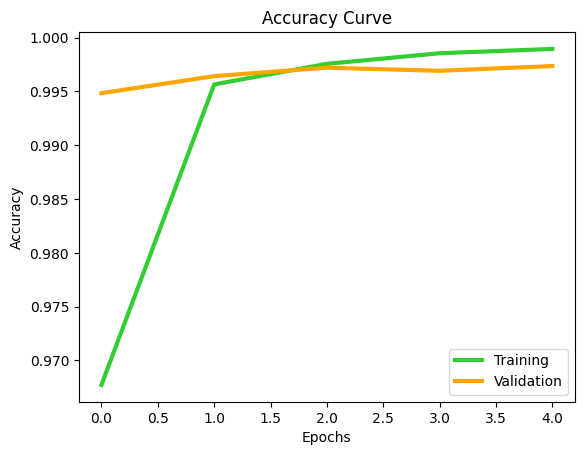

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.plot(history.history['accuracy'],linewidth=3,color='limegreen')
plt.plot(history.history['val_accuracy'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="lower right")

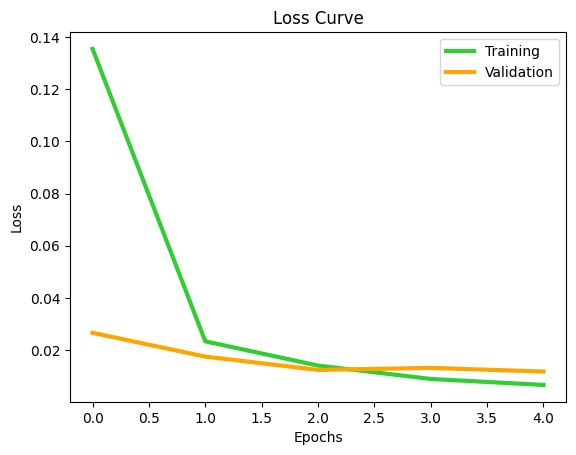

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(history.history['loss'],linewidth=3,color='limegreen')
plt.plot(history.history['val_loss'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="upper right")

### Get the Prediction

* The prediction for each input will be of shape (Num_inputs, Max_len, total output)
* The output axis is the probabilities of the token belonging to 0, 1 or 2.
    * 0 - Non disease token
    * 1 - Disease token
    * 2 - Padded token
* We take the argmax along the axis=2, which results in a shape of (Num_inputs, Max_len)
* Let's look at a sample prediction output


In [ ]:
# Load the trained model
model.load_weights('/kaggle/working/model_512d_003.h5')

In [ ]:
validation_predictions = model.predict([valid_sent_id,
                                        valid_tok_type_id,
                                        valid_att_mask])
validation_predictions_prob = validation_predictions.argmax(axis=2)

print(validation_predictions.shape)

9/9 [==============================] - 14s 1s/step
(283, 512, 3)


In [ ]:
validation_predictions_prob[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Let's get the disease tokens/phrase
* Now that we have the prediction for each sentence from the validation,we will have to get the corresponding tokens
* As we saw above the predictions are either 0, 1 or 2. So all predictions corresponding to 1 are the predicted keywords
* Given a input sentence we map the corresponding position of prediction==1 which is the Disease class we are interested in.
* Let's look at a example

Input sentence: 'the risk of colorectal cancer was significantly higher, for females there was a high risk of endometrial cancer'
<br>
token sentence: ['the', 'risk', 'of', 'color', '##ect', '##al', 'cancer', 'was', 'significantly', 'higher', ',', 'for', 'females', 'there', 'was', 'a', 'high', 'risk', 'of', 'end', '##ome', '##tri', '##al', 'cancer', '< PAD >'......'< PAD >']
<br>
Prediction: [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2......2]
<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$ => [['color', '##ect', '##al', 'cancer'], ['end', '##ome', '##tri', '##al', 'cancer']]
<br>
$\;\;\;\;\;\;\;\;\;\;\;\;$ => "colorectal cancer"

In [ ]:
def get_predicted_entities(all_prediction, sub_sentence):

    final_kwords = []
    for i, prediction in enumerate(all_prediction):
        tkns = sub_sentence[i]
        kword = ''
        kword_list = []

        for k, j in enumerate(prediction):
            if (len(prediction)>1):
                if (j==1) & (k==0):
                    # If it's the first word in the first position
                    begin = tkns[k]
                    kword = begin
                elif (j==1) & (k>=1) & (prediction[k-1]==0):
                    # Begin word is in the middle of the sentence
                    begin = tkns[k]
                    previous = tkns[k-1]

                    if begin.startswith('##'):
                        kword = previous + begin[2:]
                    else:
                        kword = begin

                    if k == (len(prediction) - 1):
                        kword_list.append(kword.rstrip().lstrip())
                elif (j==1) & (k>=1) & (prediction[k-1]!=0):
                    # Intermediate word of the same keyword
                    inter = tkns[k]

                    if inter.startswith('##'):
                        kword = kword + "" + inter[2:]
                    else:
                        kword = kword + " " + inter


                    if k == (len(prediction) - 1):
                        kword_list.append(kword.rstrip().lstrip())
                elif (j==0) & (k>=1) & (prediction[k-1] !=0):
                    # End of a keywords but not end of sentence.
                    kword_list.append(kword.rstrip().lstrip())
                    kword = ''
                    inter = ''
            else:
                if (j!=0):
                    begin = tkns[k]
                    kword = begin
                    kword_list.append(kword.rstrip().lstrip())

        final_kwords.append(kword_list)
    return final_kwords

In [ ]:
validation_predictions= get_predicted_entities(all_prediction = validation_predictions_prob,
                                               sub_sentence = valid_df.sentences_tok.values)
valid_df['prediction'] = validation_predictions
valid_df.head(10)

id                                          sentences  \
0  10807385  the remaining 101 cases from the same series n...   
1   1717985  we identified a kit gene mutation in a proband...   
2   2008213  the consequent severe diarrhoea and dehydratio...   
3   9425239  progression of somatic ctg repeat length heter...   
4   7939630  brca1 mutations in primary breast and ovarian ...   
5   2055114  the human gene for histidase histidine ammonia...   
6   1301201  homozygosity for m1v and codominant inheritanc...   
7   7759076  other cancers of interest that appeared in the...   
8   1978564  genetic linkage map of six polymorphic dna mar...   
9   9931324  here we present four novel pax6 missense mutat...   

                                            keywords  \
0                                   [ovarian cancer]   
1                                       [piebaldism]   
2                           [dehydration, diarrhoea]   
3                               [myotonic dystrophy]   
4                               [ovarian carcinomas]   
5                                     [histidinemia]   
6                        [classical phenylketonuria]   
7  [cancer of the fallopian tube, malignant melan...   
8                   [familial adenomatous polyposis]   
9  [aniridia, congenital nystagmus, displaced pup...   

                                       sentences_tok  \
0  [the, remaining, 101, cases, from, the, same, ...   
1  [we, identified, a, kit, gene, mutation, in, a...   
2  [the, con, ##se, ##quent, severe, dia, ##rr, #...   
3  [progression, of, so, ##matic, ct, ##g, repeat...   
4  [br, ##ca, ##1, mutations, in, primary, breast...   
5  [the, human, gene, for, his, ##ti, ##das, ##e,...   
6  [homo, ##zy, ##gos, ##ity, for, m1, ##v, and, ...   
7  [other, cancers, of, interest, that, appeared,...   
8  [genetic, link, ##age, map, of, six, poly, ##m...   
9  [here, we, present, four, novel, pa, ##x, ##6,...   

                                        sentences_id  \
0  [1996, 3588, 7886, 3572, 2013, 1996, 2168, 218...   
1  [2057, 4453, 1037, 8934, 4962, 16221, 1999, 10...   
2  [1996, 9530, 3366, 15417, 5729, 22939, 12171, ...   
3  [14967, 1997, 2061, 12644, 14931, 2290, 9377, ...   
4  [7987, 3540, 2487, 14494, 1999, 3078, 7388, 19...   
5  [1996, 2529, 4962, 2005, 2010, 3775, 8883, 206...   
6  [24004, 9096, 12333, 3012, 2005, 23290, 2615, ...   
7  [2060, 25409, 1997, 3037, 2008, 2596, 1999, 19...   
8  [7403, 4957, 4270, 4949, 1997, 2416, 26572, 18...   
9  [2182, 2057, 2556, 2176, 3117, 6643, 2595, 257...   

                               sentences_tok_type_id  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                  sentences_att_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
6  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
7  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
9  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              labels  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 1, 1, 1, 1